### Import scanpy

In [1]:
import scanpy as sc
import scanpy.external as sce
#sc.logging.print_versions()
#sc.logging.print_memory_usage()
#sc.settings.verbosity = 2
import os,sys
import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.ticker as mticker


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

In [3]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.8.12


# Load data

In [4]:
adata = sc.read_h5ad('backups_JZ_2022/clean_kidney_304_15tr_25c_batch_corrected_50236x2000_220315_12h14.h5ad') 

In [5]:
# overwrite obs with the most recent version
filename = 'backups_JZ_2022/corrected_obs_info_50236x32_221012_12h04.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)
adata.obs = obs

In [6]:
adata.obs

,library,total_counts,pct_counts_mito,library2,sample,patient,pT stage,seq_date,beads,operation,...,n_counts,no_dblt_no_rbc,sp_cl_43,cell_type,broad_cell_type,color,cell_group,stage_color,patient_color,group_color
2,N14,449,0.668151,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,449,True,40,TAM 4,Immune,#9a5ce0,Myeloid cells,#8c1a1a,#e87f7f,#85619c
19,N14,449,4.23163,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,449,True,37,TAM 3,Immune,#943886,Myeloid cells,#8c1a1a,#e87f7f,#85619c
363,N14,1229,10.6591,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,1229,True,22,Tumor cells 2,Tumor,#b06c6c,Tumor cells,#8c1a1a,#e87f7f,#db2f2c
433,N14,432,6.94444,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,432,True,27,Tumor cells 3,Tumor,#db2f2c,Tumor cells,#8c1a1a,#e87f7f,#db2f2c
444,N14,502,4.98008,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,502,True,28,Tumor vasculature 4,Endothelial,#a35927,Endothelium,#8c1a1a,#e87f7f,#e07c57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865536,Tumor0228,683,9.37042,T4_old,T4,P4,pT3a,old,old,Open,...,683,True,30,TAM 2,Immune,#532b6b,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865584,Tumor0228,1473,6.51731,T4_old,T4,P4,pT3a,old,old,Open,...,1473,True,30,TAM 2,Immune,#532b6b,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865642,Tumor0228,498,9.43775,T4_old,T4,P4,pT3a,old,old,Open,...,498,True,37,TAM 3,Immune,#943886,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865726,Tumor0228,421,19.2399,T4_old,T4,P4,pT3a,old,old,Open,...,421,True,27,Tumor cells 3,Tumor,#db2f2c,Tumor cells,#8c1a1a,#70c3d4,#db2f2c


### Scale (normalize) data

In [7]:
adata = adata.raw.to_adata()

In [9]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[ 449.]
 [ 449.]
 [1229.]
 [ 432.]
 [ 502.]]

[[10000.001]
 [10000.   ]
 [10000.001]
 [10000.   ]
 [10000.   ]]


In [10]:
#some parameters for plots
import matplotlib as mpl
mpl.rc('font',family='Arial')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Get genes enriched within vasculature sub-populations

In [11]:
adata.obs['cell_type'].unique()

array(['TAM 4', 'TAM 3', 'Tumor cells 2', 'Tumor cells 3',
       'Tumor vasculature 4', 'TAM 1', 'CD8 T cells', 'TAM 2',
       'Resting/memory T cells', 'Cytotoxic T cells',
       'Tumor vasculature 2', 'Tumor vasculature 1',
       'Non-classical monocytes', 'Mesangial/vSMCs',
       'IGHG-high plasma cells', 'Mast cells', 'Tumor vasculature 3',
       'Plasma cells', 'Tumor AVR-like vasculature', 'Cycling', 'vSMCs',
       'NK cells', 'Classical monocytes', 'B cells', 'Myofibroblasts',
       'Regulatory T cells', 'Tumor cells 1', 'Proximal tubule', 'AVR',
       'Epithelial progenitor-like cells', 'tAL of LOH',
       'Glomerular endothelium', 'Principal cells', 'TAL of LOH', 'DVR',
       'Type A-ICs', 'OM Type A-ICs', 'Type B-IC', 'Podocytes', 'DCT/CNT'],
      dtype=object)

In [12]:
#subset cells using cmask
cmask = adata.obs['cell_type'].isin(['Tumor vasculature 1', 'Tumor vasculature 2', 
                                     'Tumor vasculature 3', 'Tumor vasculature 4',
                                     'Tumor AVR-like vasculature', 'AVR', 'DVR', 'Glomerular endothelium']).values
#cmask = np.repeat(True,adata.shape[0])
print(cmask.sum())

6394


In [19]:
# get centroids
thelabel = 'cell_type'
centroids = rz.centroids(thelabel,adata[cmask])

In [20]:
# For each cluster, find genes that are statistically significantly higher or lower in cluster x compared to
# all other cells collectively

#label-free filter to remove very low abundance genes:
min_counts = 15
min_cells = 15

In [21]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

6758 genes passing abundance filter


In [113]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for cluster in meta[thelabel].unique():
    counter+=1
    mask1 = (meta[thelabel]==cluster).values
    mask2 = mask1==False
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    mwu_dict[cluster] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print("%d/%d"%(counter,len(meta[thelabel].unique())))
    print(cluster, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

fname = 'backups_JZ_2022/1515vasculature_clusters_vs_rest_MWU_result_dict_%s%s'%(rz.now(), thelabel)
print(fname)
rz.save_stuff(mwu_dict,fname)

1000
2000
3000
4000
5000
6000
1/8
Tumor vasculature 4 done 6394
1000
2000
3000
4000
5000
6000
2/8
Tumor vasculature 2 done 6394
1000
2000
3000
4000
5000
6000
3/8
Tumor vasculature 1 done 6394
1000
2000
3000
4000
5000
6000
4/8
Tumor vasculature 3 done 6394
1000
2000
3000
4000
5000
6000
5/8
Tumor AVR-like vasculature done 6394
1000
2000
3000
4000
5000
6000
6/8
AVR done 6394
1000
2000
3000
4000
5000
6000
7/8
Glomerular endothelium done 6394
1000
2000
3000
4000
5000
6000
8/8
DVR done 6394
119.2220470905304
backups_JZ_2022/1515vasculature_clusters_vs_rest_MWU_result_dict_221109_15h58cell_type


In [13]:
#continuing from backup
mwu_dict = rz.load_stuff('backups_JZ_2022/1515vasculature_clusters_vs_rest_MWU_result_dict_221109_15h58cell_type.pickle')

In [23]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [17]:
print(thelabel)
fcdict = rz.get_fc_to_all_other(
        lab = thelabel,
        meta = adata[cmask].obs,
        E = adata[cmask].X,
        pseudo = pseudo,
        gene_list = adata.var_names,
        )

cell_type


In [18]:
# leave only genes with a significant difference.
fcdictsig = {}

# before the mwu test, I prefiltered genes on abundance, apply this mask here as well
print(gmask.sum())
for key,value in fcdict.items():
    sigmask = (mwu_dict[key]['fdr']<0.05).values
    fcdictsig[key] = value[gmask][sigmask]
    print(key,sigmask.sum(),len(fcdictsig[key]))

6758
Tumor vasculature 4 6287 6287
Tumor vasculature 2 2565 2565
Tumor vasculature 1 5061 5061
Tumor vasculature 3 587 587
Tumor AVR-like vasculature 2075 2075
AVR 2730 2730
Glomerular endothelium 1410 1410
DVR 1216 1216


In [19]:
# nr genes to consider:
upto = 15 #genes to generate heatmap and table S10

frame = {}
for key,value in fcdictsig.items():
    s = value.sort_values(ascending=False)[:upto]
    key2 = str(key)+'_FC'
    frame[str(key)] = s.index
    frame[key2] = s.values
frame = pd.DataFrame(frame)
frame[[i for i in frame.columns if "FC" in i]].min() #ok, all above 1.

Tumor vasculature 4_FC           1.300676
Tumor vasculature 2_FC           2.401833
Tumor vasculature 1_FC           1.785793
Tumor vasculature 3_FC           3.155826
Tumor AVR-like vasculature_FC    2.350830
AVR_FC                           2.512118
Glomerular endothelium_FC        2.968899
DVR_FC                           3.375497
dtype: float32

In [27]:
outdir = 'outputs_JZ_2022/'

In [120]:
#save the results
fname = outdir+'vasculature_lists1515_enriched_genes_top_%d_%s_%s.xlsx'%(upto,thelabel,rz.now())
print(fname)
frame.to_excel(fname)

outputs_JZ_2022/vasculature_lists1515_enriched_genes_top_15_cell_type_221109_15h58.xlsx


In [121]:
frame

,Tumor vasculature 4,Tumor vasculature 4_FC,Tumor vasculature 2,Tumor vasculature 2_FC,Tumor vasculature 1,Tumor vasculature 1_FC,Tumor vasculature 3,Tumor vasculature 3_FC,Tumor AVR-like vasculature,Tumor AVR-like vasculature_FC,AVR,AVR_FC,Glomerular endothelium,Glomerular endothelium_FC,DVR,DVR_FC
0,MTRNR2L8,1.581719,ENPP2,9.767940,VWA1,2.616652,LY6H,21.325401,ACKR1,17.103901,DNASE1L3,8.987769,CRHBP,14.588342,SERPINE2,6.103241
1,NEAT1,1.552168,IGFBP3,9.256742,COL4A1,2.549790,PGF,9.738758,CLU,7.615246,ALDOB,4.359324,SOST,13.490231,S100A4,5.847677
2,C1QA,1.478222,STC1,4.198276,THY1,2.504225,APOD,7.798020,ADIRF,4.756512,CCL2,3.913952,EHD3,9.006966,SLC14A1,5.221536
3,RPLP0,1.445482,ESM1,3.315153,COL4A2,2.327312,CHST1,6.027846,NNMT,4.643841,MT1G,3.732059,PLAT,7.973589,GLUL,5.183988
4,APOC1,1.437539,ANGPT2,3.214932,RGCC,2.125020,CLDN5,5.740094,PTGDS,4.559468,MT1X,3.230410,IGFBP5,7.597638,KCTD12,4.928084
5,EEF1A1,1.411129,PRSS23,3.098238,PLVAP,2.105346,PRSS2,5.154946,TFF3,3.768075,GPX3,3.160701,EMCN,7.042589,EMP3,4.730494
6,NPM1,1.399328,RBP7,2.898030,COL15A1,2.056567,PXDN,4.063362,IL33,3.592219,MT1M,2.949306,MEG3,4.346837,PPP1R14A,4.469952
7,ACTB,1.380304,INHBB,2.804395,HSPG2,1.986083,LGALS1,3.859044,DUSP23,3.522760,IGFBP5,2.762062,IL13RA2,3.636900,ABI3BP,4.366666
8,REN,1.352795,GJA1,2.752868,SPRY1,1.955724,IL32,3.757302,COL3A1,3.080045,HLA-DQA1,2.701019,SYNE1,3.535199,SSUH2,4.359886
9,RPL7A,1.331946,EFNB2,2.743428,CA2,1.906023,LOX,3.586167,S100A6,2.945975,MT2A,2.608034,LINC00551,3.501744,AQP1,4.336555


### Perform hierarchical clustering and plot heatmap

In [17]:
clnames = sorted(mwu_dict.keys())


In [24]:
# select only columns with gene names:
genes = frame[clnames].values.flatten()
print(len(genes))

# I anticipate some genes to be repeated
genes = rz.oset(genes)
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

#hierarchically cluster
import scipy.cluster
hierdict = rz.hier_cluster(heat, hier_clust_cols=True, method='ward',metric='sqrt_correlation')

print(hierdict.keys())

heat = hierdict['data']

120
115
dict_keys(['data', 'row_link', 'col_link'])


In [25]:
hierdict['data']

,Tumor vasculature 3,Tumor vasculature 2,Tumor vasculature 4,Tumor vasculature 1,Tumor AVR-like vasculature,DVR,AVR,Glomerular endothelium
CLDN5,2.518806,0.303747,0.131733,-0.144981,-1.113284,1.799572,-1.205567,-0.768250
IL32,1.910358,-0.450529,0.205615,0.072673,-0.475065,0.861806,-0.076528,-0.185460
LGALS1,1.812436,-0.603721,0.221582,0.120769,-0.654374,0.081381,-0.701649,-0.086248
MMP2,1.687489,-0.166601,0.149339,0.288310,-0.176796,0.272339,-0.454500,-0.329458
HOMER3,1.761225,-0.121868,0.044642,0.053512,-0.084635,0.218342,-0.160928,-0.046068
...,...,...,...,...,...,...,...,...
EMCN,-1.170682,0.065327,-0.398071,0.164067,-0.505722,-0.068426,1.346094,3.078124
SGK1,-0.651391,-0.364732,0.006891,-0.006924,-0.332599,0.331074,1.057997,1.737061
HLA-DQA1,-0.294248,-0.211961,0.101366,-0.410434,0.775045,-0.109030,1.557185,1.234166
PLAT,-0.826738,-0.695958,-0.221194,-0.225231,1.314590,0.191746,1.577399,3.362816


outputs_JZ_2022//dendrogram_NOlabels_vasc_new__labels_cell_type_230523_11h46.png


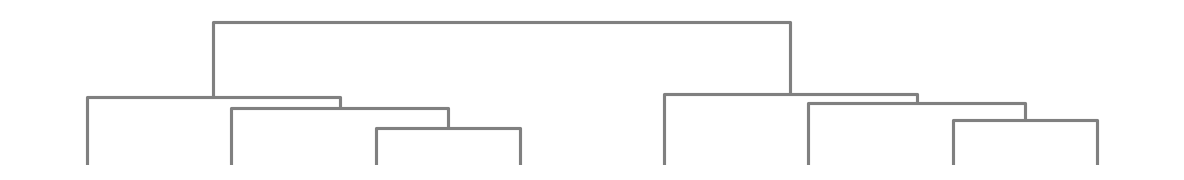

In [28]:
##NOTE
# this code is ran multiple times: 1st time image is saved with labels
# second time - without, to incorporate into the plot

a,fig,gs = rz.startfig(20,3)
col_link = hierdict['col_link']
dendro = scipy.cluster.hierarchy.dendrogram(
                                 col_link, orientation='top', ax=a,
                                 above_threshold_color='0.5',
                                 color_threshold = 0,
                                    )

#a.set_xticklabels(heat.columns,rotation=270,fontsize=5)
a.set_xticks([])
a.axis('off')
rz.showspines(a)

gs.tight_layout(fig)
fname = outdir+'/dendrogram_NOlabels_vasc_new__labels_%s_%s.png'%(thelabel,rz.now())
print(fname)
#plt.savefig(fname, transparent=True, dpi=50)

## Heatmap variant 1 - diverging colormap log2FC

In [29]:
heat2 = heat

In [31]:
#choosing the colormap
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='cmap', 
    colors=['#4d4dff', #blue
            '#D3D3D3', #grey
            '#cc0000' #dark-red
           ])

In [32]:

def yticks_fancy(a,totick,labels_all, color_dict,emptychar = '',fontsize=5):
    
    """
    utility function originally made for ticking only a subset of selected genes in a genes x observations heatmap.
    example of use: yticks_fancy(a,['Csf1r','Ccr2','','','Arg1','S100a9'],genes_by_cells.index)
    input:
        a - axis with heatmap
        totick - list of yticklabels to display. Use the string defined by
        emptychar to add spacing between groups of genes.
        labels_all - all yticklabels.
        emptychar - string that will be treated as white space
        
    returns: nothing
    
    """


    a.set_yticks([])
    leftshift = 0
    totick = np.array(totick)
    nr_slots = len(totick)
    tickmask = np.array([i!=emptychar for i in totick])
    totick = totick[tickmask]
    y_right = np.array([pd.Index(labels_all).get_loc(i) for i in totick])
    
    #if genes were not typed in in the correct order, account for that to avoid lines crossing
    tickorder = np.argsort(y_right)
    y_right = y_right[tickorder]
    totick = totick[tickorder]
    y_left = np.linspace(0,len(labels_all),nr_slots)[tickmask]
    for l,r,gene in zip(y_left,y_right,totick):
        a.plot((-0.8-leftshift,-0.5-leftshift),(r,r),lw=0.5,color='0.2')
        a.plot((-1.2-leftshift,-0.8-leftshift),(l,r),lw=0.5,color='0.2')
        a.plot((-1.5-leftshift,-1.2-leftshift),(l,l),lw=0.5,color='0.2')
        a.text(-1.6-(leftshift*1.6),l,gene,ha='right',va='center',fontsize=fontsize, color = color_dict[gene])

In [33]:
totick = heat.index

-3.5481658 4.49552
2020heatmap_cell_type_upto_10_230523_11h47


<ipython-input-35-ca7feb920e9b>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig)


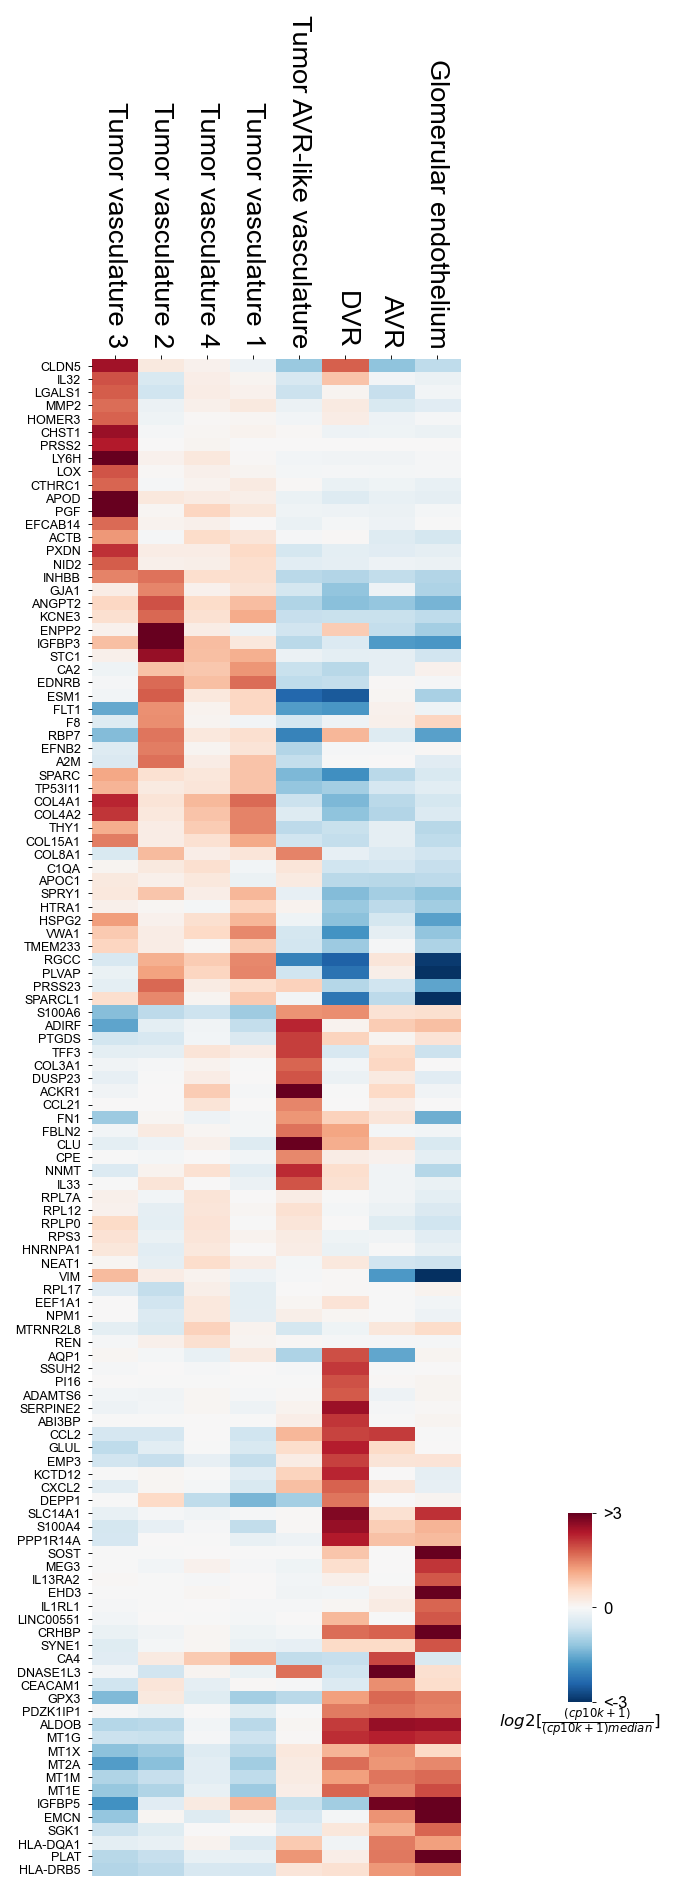

In [35]:
#a,fig,gs = rz.startfig(1+heat.shape[1]/3.,4+heat.shape[0]/40.,frameon=False)
a,fig,gs = rz.startfig(8,32,frameon=False)

upto=10
cmap = 'RdBu_r'
cbarlabel = r'$log2[\frac{(cp10k+1)}{(cp10k+1) median}]$'

vmin=-3
vmax=3
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap, interpolation='none')

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270, fontsize=13)
a.xaxis.tick_top()

# y ticks
#yticks_fancy(a,totick,labels_all = heat.index, color_dict=color_dict, fontsize=11)

a.set_yticks(np.arange(heat.shape[0]))
a.set_yticklabels(totick,fontsize=6)

# colorbar
#cbar = fig.colorbar(hmap,orientation='vertical')
#cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]


#norm = mpl.colors.Normalize(vmin, vmax)
caxb = fig.add_axes([1.2, 0.1, 0.05, 0.1])
cbar = fig.colorbar(hmap, cax=caxb, orientation='vertical')
cbar.outline.set_visible(False)
#c = [vmin, 0,  vmax]
cbar.set_ticks(c)
cbar.ax.set_yticklabels(clabs, fontsize = 8)
cbar.set_ticklabels(clabs)
cbar.ax.set_title(cbarlabel,
                  fontsize=8, pad = 15, y=-0.3)

gs.tight_layout(fig)
fname = '2020heatmap_%s_upto_%d_%s'%(thelabel,upto,rz.now())
print(fname)
#plt.savefig(outdir+'%s.pdf'%fname,dpi=100)
#plt.savefig(outdir+'%s.png'%fname,dpi=100,  bbox_inches='tight')

## Heatmap version 2 - percentage max expression

In [36]:
#variant 2 - percentage max expression

heat = centroids[genes].copy()
heat = heat.loc[:,heat.max() > 0]
heat = heat/heat.max()*100.
heat = heat.T

#choosing the colormap
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='cmap', 
    colors=['#D3D3D3', #grey
            #'#ff8080', 
            '#cc0000' #dark-red
           ])
#hierarchically cluster
import scipy.cluster
hierdict = rz.hier_cluster(heat, hier_clust_cols=True, method='ward',metric='sqrt_correlation')

print(hierdict.keys())

heat = hierdict['data']

dict_keys(['data', 'row_link', 'col_link'])


In [37]:
heat

,Tumor vasculature 3,Tumor vasculature 2,Tumor vasculature 4,Tumor vasculature 1,Tumor AVR-like vasculature,DVR,AVR,Glomerular endothelium
RGCC,24.331469,75.721161,61.593742,100.000000,6.417101,4.272000,45.436771,2.361909
PLVAP,29.144972,83.375809,55.324726,100.000000,21.469992,4.672332,38.753719,1.459099
CA2,20.512051,66.879913,62.141781,100.000000,6.388222,3.047618,16.432844,29.086971
EDNRB,17.126419,100.000000,50.309639,98.444878,3.313100,4.125486,18.989229,17.464287
INHBB,88.519875,100.000000,34.301636,33.996567,1.256483,0.138709,2.284092,0.157536
...,...,...,...,...,...,...,...,...
MT1G,0.316987,0.164977,7.878137,0.565895,9.170736,90.726181,100.000000,93.104500
PDZK1IP1,13.274063,9.329638,14.796268,5.056592,13.937428,96.362221,100.000000,90.750923
GPX3,5.574213,32.577633,17.921478,8.806493,11.354492,69.238907,100.000000,88.575844
ALDOB,0.000000,0.323680,7.158402,0.319091,8.932049,67.369148,100.000000,97.668480


In [38]:
label = 'vasculature_genes'

0.0 100.0
heatmap_pctmax995_vasculature_vasculature_genes_hq


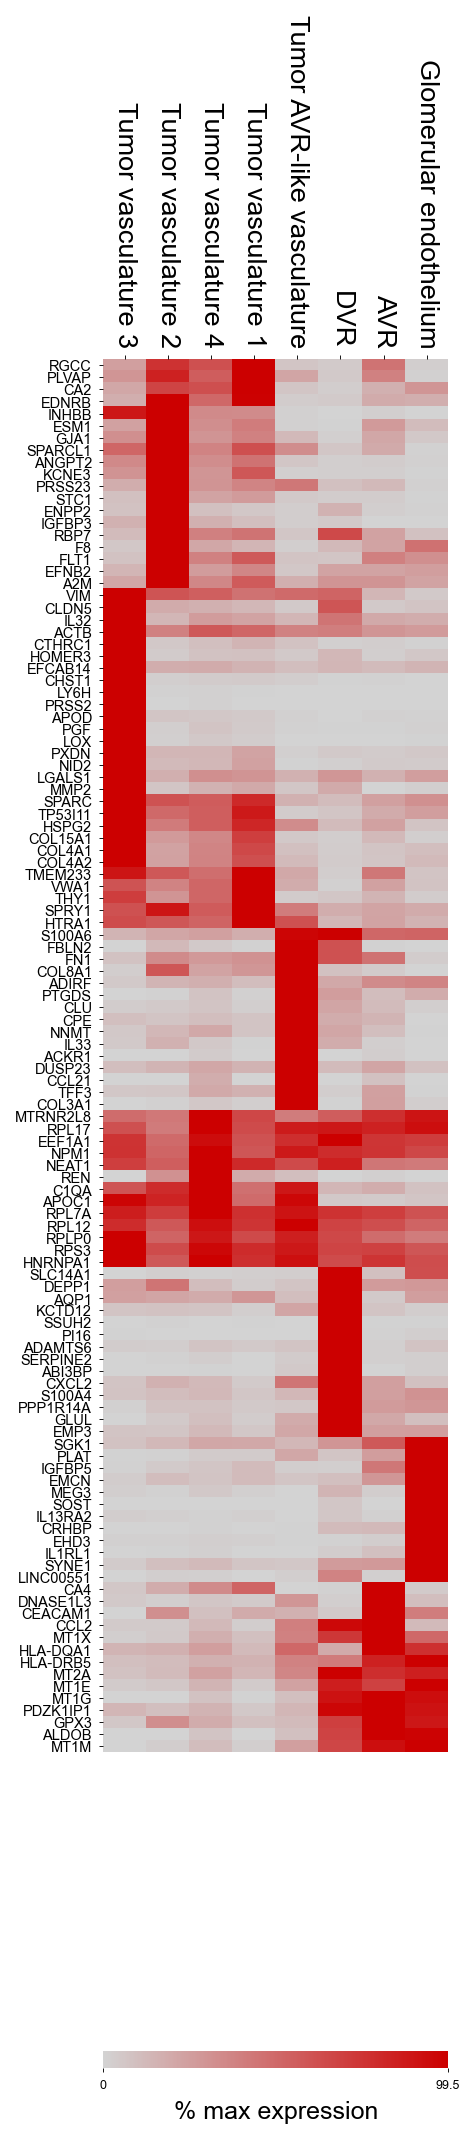

In [47]:

a,fig,gs = rz.startfig(8,40,frameon=False)

cmap = cmap
cbarlabel = '% max expression'

vmin=0
vmax=99.5

print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270, fontsize=13)
a.xaxis.tick_top()

# y ticks:
a.set_yticks(np.arange(heat.shape[0]))
a.set_yticklabels(heat.index, fontsize =7)


# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,vmax]
cbar.set_ticks(c)
cbar.set_ticklabels(c)
cbar.set_label(cbarlabel, fontsize=12)


gs.tight_layout(fig)
fname = 'heatmap_pctmax995_vasculature_%s_hq'%(label)
print(fname)

plt.savefig(outdir+'%s_v2.png'%fname,dpi=600)
plt.savefig(outdir+'%s_v2.pdf'%fname,dpi=600)

# Get genes enriched within stromal sub-populations

In [48]:
adata.obs['cell_type'].unique()

array(['TAM 4', 'TAM 3', 'Tumor cells 2', 'Tumor cells 3',
       'Tumor vasculature 4', 'TAM 1', 'CD8 T cells', 'TAM 2',
       'Resting/memory T cells', 'Cytotoxic T cells',
       'Tumor vasculature 2', 'Tumor vasculature 1',
       'Non-classical monocytes', 'Mesangial/vSMCs',
       'IGHG-high plasma cells', 'Mast cells', 'Tumor vasculature 3',
       'Plasma cells', 'Tumor AVR-like vasculature', 'Cycling', 'vSMCs',
       'NK cells', 'Classical monocytes', 'B cells', 'Myofibroblasts',
       'Regulatory T cells', 'Tumor cells 1', 'Proximal tubule', 'AVR',
       'Epithelial progenitor-like cells', 'tAL of LOH',
       'Glomerular endothelium', 'Principal cells', 'TAL of LOH', 'DVR',
       'Type A-ICs', 'OM Type A-ICs', 'Type B-IC', 'Podocytes', 'DCT/CNT'],
      dtype=object)

In [49]:
#subset cells using cmask
cmask = adata.obs['cell_type'].isin(['Mesangial/vSMCs', 'vSMCs', 'Myofibroblasts']).values
print(cmask.sum())

2846


In [50]:
# get centroids
thelabel = 'cell_type'
centroids = rz.centroids(thelabel,adata[cmask])

In [51]:
# For each cluster, find genes that are statistically significantly higher or lower in cluster x compared to
# all other cells collectively

#label-free filter to remove very low abundance genes:
min_counts = 15
min_cells = 15

In [52]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

2717 genes passing abundance filter


In [194]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for cluster in meta[thelabel].unique():
    counter+=1
    mask1 = (meta[thelabel]==cluster).values
    mask2 = mask1==False
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    mwu_dict[cluster] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print("%d/%d"%(counter,len(meta[thelabel].unique())))
    print(cluster, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

fname = 'backups_JZ_2022/1515stromal_clusters_vs_rest_MWU_result_dict_%s%s'%(rz.now(), thelabel)
print(fname)
rz.save_stuff(mwu_dict,fname)

1000
2000
1/3
Mesangial/vSMCs done 2846
1000
2000
2/3
vSMCs done 2846
1000
2000
3/3
Myofibroblasts done 2846
10.70914101600647
backups_JZ_2022/1515stromal_clusters_vs_rest_MWU_result_dict_221110_14h49cell_type


In [53]:
# if continuing from backup
mwu_dict = rz.load_stuff('backups_JZ_2022/1515stromal_clusters_vs_rest_MWU_result_dict_221110_14h49cell_type.pickle')

In [96]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [97]:
print(thelabel)
fcdict = rz.get_fc_to_all_other(
        lab = thelabel,
        meta = adata[cmask].obs,
        E = adata[cmask].X,
        pseudo = pseudo,
        gene_list = adata.var_names,
        )

cell_type


In [98]:
# leave only genes with a significant difference.
fcdictsig = {}

# before the mwu test, I prefiltered genes on abundance, apply this mask here as well
print(gmask.sum())
for key,value in fcdict.items():
    sigmask = (mwu_dict[key]['fdr']<0.05).values
    fcdictsig[key] = value[gmask][sigmask]
    print(key,sigmask.sum(),len(fcdictsig[key]))

2717
Mesangial/vSMCs 868 868
vSMCs 777 777
Myofibroblasts 626 626


In [99]:
# nr genes to consider:
upto = 20 #genes to generate heatmap and table S13

frame = {}
for key,value in fcdictsig.items():
    s = value.sort_values(ascending=False)[:upto]
    key2 = str(key)+'_FC'
    frame[str(key)] = s.index
    frame[key2] = s.values
frame = pd.DataFrame(frame)
frame[[i for i in frame.columns if "FC" in i]].min() #ok, all above 1.

Mesangial/vSMCs_FC    1.601197
vSMCs_FC              2.251434
Myofibroblasts_FC     2.766023
dtype: float32

In [54]:
outdir = 'outputs_JZ_2022/'

In [101]:
fname = outdir+'stromal_1515_enriched_genes_top_%d_%s_%s.xlsx'%(upto,thelabel,rz.now())
print(fname)
#frame.to_excel(fname)

outputs_JZ_2022/stromal_1515_enriched_genes_top_20_cell_type_230512_12h44.xlsx


## Heatmap variant 1 - diverging colormap log2FC

In [61]:
clnames = sorted(mwu_dict.keys())


In [62]:
# select only columns with gene names:
genes = frame[clnames].values.flatten()
print(len(genes))

# I anticipate some genes to be repeated
genes = rz.oset(genes)
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

#hierarchically cluster
import scipy.cluster
hierdict = rz.hier_cluster(heat, hier_clust_cols=True, method='ward',metric='sqrt_correlation')

print(hierdict.keys())

heat = hierdict['data']

60
60
dict_keys(['data', 'row_link', 'col_link'])


In [63]:
heat2 = heat

In [64]:
import matplotlib as mpl
mpl.rc('font',family='Arial')

In [65]:
#choosing the colormap
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='cmap', 
    colors=['#4d4dff', #blue
            '#D3D3D3', #grey
            '#cc0000' #dark-red
           ])

In [66]:

def yticks_fancy(a,totick,labels_all, color_dict,emptychar = '',fontsize=5):
    
    """
    utility function originally made for ticking only a subset of selected genes in a genes x observations heatmap.
    example of use: yticks_fancy(a,['Csf1r','Ccr2','','','Arg1','S100a9'],genes_by_cells.index)
    input:
        a - axis with heatmap
        totick - list of yticklabels to display. Use the string defined by
        emptychar to add spacing between groups of genes.
        labels_all - all yticklabels.
        emptychar - string that will be treated as white space
        
    returns: nothing
    
    """


    a.set_yticks([])
    leftshift = 0
    totick = np.array(totick)
    nr_slots = len(totick)
    tickmask = np.array([i!=emptychar for i in totick])
    totick = totick[tickmask]
    y_right = np.array([pd.Index(labels_all).get_loc(i) for i in totick])
    
    #if genes were not typed in in the correct order, account for that to avoid lines crossing
    tickorder = np.argsort(y_right)
    y_right = y_right[tickorder]
    totick = totick[tickorder]
    y_left = np.linspace(0,len(labels_all),nr_slots)[tickmask]
    for l,r,gene in zip(y_left,y_right,totick):
        a.plot((-0.8-leftshift,-0.5-leftshift),(r,r),lw=0.5,color='0.2')
        a.plot((-1.2-leftshift,-0.8-leftshift),(l,r),lw=0.5,color='0.2')
        a.plot((-1.5-leftshift,-1.2-leftshift),(l,l),lw=0.5,color='0.2')
        a.text(-1.6-(leftshift*1.6),l,gene,ha='right',va='center',fontsize=fontsize, color = color_dict[gene])

In [67]:
totick = heat.index

In [68]:
corder = ['vSMCs', 'Myofibroblasts', 'Mesangial/vSMCs']

In [69]:
heat = heat[corder[::-1]]

-1.8733428 3.6416216
stromal_heatmap_cell_type_upto_15_230523_14h06


<ipython-input-70-8b4a6424096e>:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig)


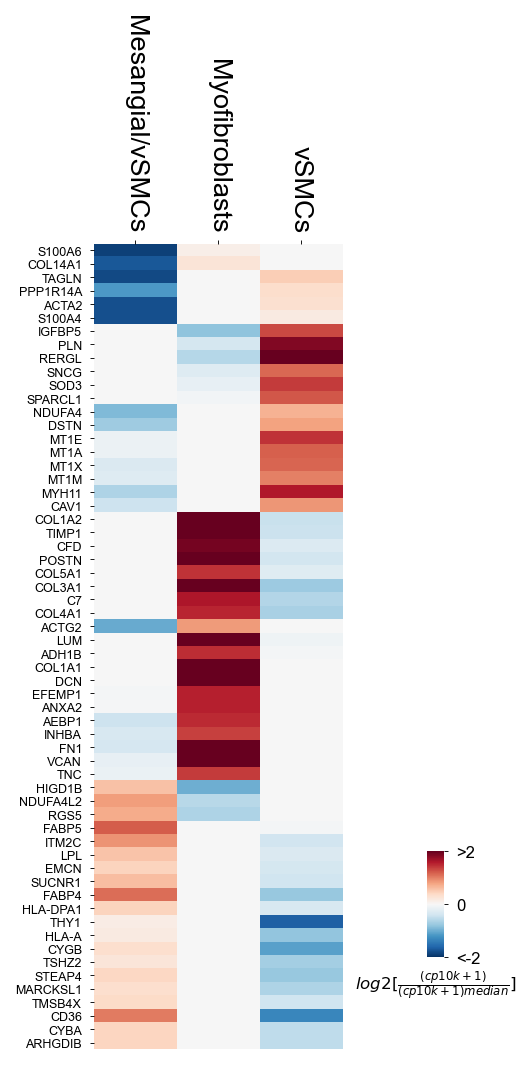

In [70]:
#a,fig,gs = rz.startfig(1+heat.shape[1]/3.,4+heat.shape[0]/40.,frameon=False)
a,fig,gs = rz.startfig(6,18,frameon=False)

upto=15
cmap = 'RdBu_r'
cbarlabel = r'$log2[\frac{(cp10k+1)}{(cp10k+1) median}]$'

vmin=-2
vmax=2
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap, interpolation='none')

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270, fontsize=13)
a.xaxis.tick_top()

# y ticks
#yticks_fancy(a,totick,labels_all = heat.index, color_dict=color_dict, fontsize=11)

a.set_yticks(np.arange(heat.shape[0]))
a.set_yticklabels(totick,fontsize=6)

# colorbar
#cbar = fig.colorbar(hmap,orientation='vertical')
#cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]


#norm = mpl.colors.Normalize(vmin, vmax)
caxb = fig.add_axes([1.2, 0.1, 0.05, 0.1])
cbar = fig.colorbar(hmap, cax=caxb, orientation='vertical')
cbar.outline.set_visible(False)
#c = [vmin, 0,  vmax]
cbar.set_ticks(c)
cbar.ax.set_yticklabels(clabs, fontsize = 8)
cbar.set_ticklabels(clabs)
cbar.ax.set_title(cbarlabel,
                  fontsize=8, pad = 15, y=-0.6)

gs.tight_layout(fig)
fname = 'stromal_heatmap_%s_upto_%d_%s'%(thelabel,upto,rz.now())
print(fname)
#plt.savefig(outdir+'%s.pdf'%fname,dpi=100)
#plt.savefig(outdir+'%s.png'%fname,dpi=100,  bbox_inches='tight')

## Heatmap version 2 - percentage max expression

In [71]:


heat = centroids[genes].copy()
heat = heat.loc[:,heat.max() > 0]
heat = heat/heat.max()*100.
heat = heat.T

#choosing the colormap
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='cmap', 
    colors=['#D3D3D3', #grey
            #'#ff8080', 
            '#cc0000' #dark-red
           ])
#hierarchically cluster
import scipy.cluster
hierdict = rz.hier_cluster(heat, hier_clust_cols=True, method='ward',metric='sqrt_correlation')

print(hierdict.keys())

heat = hierdict['data']

dict_keys(['data', 'row_link', 'col_link'])


In [73]:
label = 'stromal_genes'

In [74]:
heat = heat[corder[::-1]]

0.4596331 100.0
heatmap_pctmax995_stromal_stromal_genes_230523_14h08


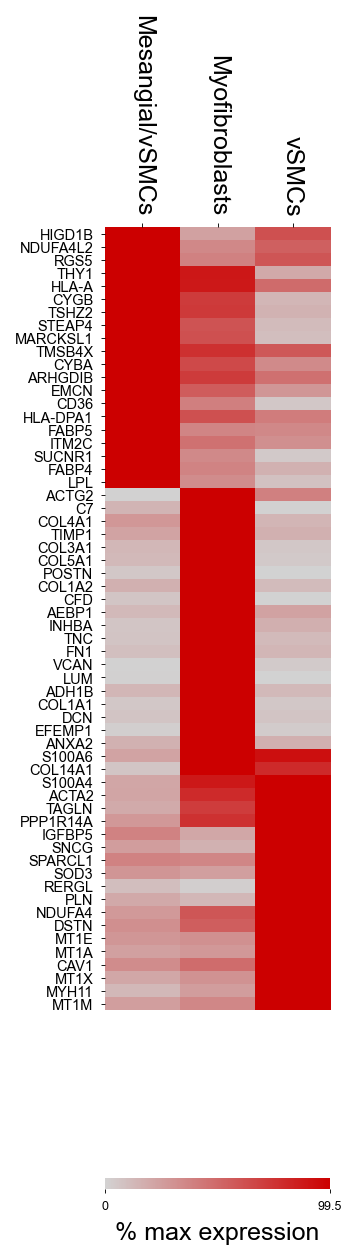

In [79]:

a,fig,gs = rz.startfig(6,23,frameon=False)

cmap = cmap
cbarlabel = '% max expression'

vmin=0
vmax=99.5

print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270, fontsize=12)
a.xaxis.tick_top()

# y ticks:
a.set_yticks(np.arange(heat.shape[0]))
a.set_yticklabels(heat.index, fontsize =7)

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,vmax]
cbar.set_ticks(c)
cbar.set_ticklabels(c)
cbar.set_label(cbarlabel, fontsize=12)


gs.tight_layout(fig)
fname = 'heatmap_pctmax995_stromal_%s_%s'%(label,rz.now())
print(fname)
plt.savefig(outdir+'%s_v2.png'%fname,dpi=600)
plt.savefig(outdir+'%s_v2.pdf'%fname,dpi=600)